In [0]:
COLAB = True # NOTE change me if not running on Colab :D

In [113]:
if COLAB:
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
    print("                                Hey!                                ")
    print("    Don't forget to enter the authorization code for Drive below    ")
    print("                                 ;)                                 ")
    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                                Hey!                                
    Don't forget to enter the authorization code for Drive below    
                                 ;)                                 
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


## Importing libs

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [4]:
if COLAB:
    try:
        # Colab only
        %tensorflow_version 2.x
    except Exception:
        pass

TensorFlow 2.x selected.


In [5]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [0]:
import warnings
from time import time, strftime

In [7]:
strftime('%X')

'00:01:18'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [8]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
if COLAB:
    PATH_TO_DATA = os.path.join("drive", "My Drive", "unicamp", "%ic", "mc886", "fashion-mnist-dataset")
    !ls drive/My\ Drive/unicamp/%ic/mc886/fashion-mnist-dataset/
else:
    PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")
    !ls ../fashion-mnist-dataset/

fashion-mnist_test.csv	fashion-mnist_train.csv  README.txt


In [0]:
# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [0]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [0]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [13]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [14]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [15]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [0]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [17]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [0]:
xs_train = xs_train.astype('float32') / 255.0
xs_val   = xs_val.astype('float32')   / 255.0
xs_test  = xs_test.astype('float32')  / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [19]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [20]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [0]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [22]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [23]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


_obs.:_ `Y_foo` is only a one-hot encoded version of `ys_foo` (so we use `ys_foo` in some places below, to avoid calling `np.argmax`)

## Add helper functions

In [0]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [0]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

In [0]:
MAX_EPOCHS = 64
BATCH_SIZE = 512
TF_VERBOSE = 1 # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [0]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = ([keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
                 if not early_stopping else
                 [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)])
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=TF_VERBOSE
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

### 1.1. MLP

In [0]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [0]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [35]:
strftime('%X')

'00:07:38'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 2s 51us/sample - loss: 0.6633 - accuracy: 0.7741 - val_loss: 0.4568 - val_accuracy: 0.8432
Epoch 2/64
48000/48000 [==============================] - 1s 15us/sample - loss: 0.4276 - accuracy: 0.8531 - val_loss: 0.4092 - val_accuracy: 0.8596
Epoch 3/64
48000/48000 [==============================] - 1s 15us/sample - loss: 0.3851 - accuracy: 0.8665 - val_loss: 0.3899 - val_accuracy: 0.8656
Epoch 4/64
48000/48000 [==============================] - 1s 14us/sample - loss: 0.3598 - accuracy: 0.8772 - val_loss: 0.3671 - val_accuracy: 0.8730
Epoch 5/64
48000/48000 [==============================] - 1s 20us/sample - loss: 0.3365 - accuracy: 0.8839 - val_loss: 0.3595 - val_accuracy: 0.8745
Epoch 6/64
48000/48000 [==============================] - 1s 24us/sample - loss: 0.3189 - accuracy: 0.8907 - val_loss: 0.3538 - val_accuracy: 0.8748
Epoch 7/64
48000/48000 [===========

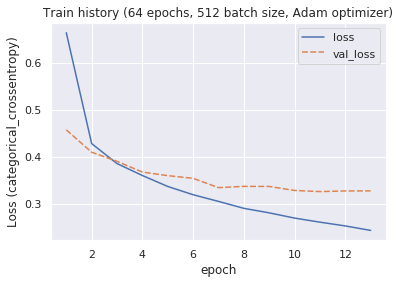

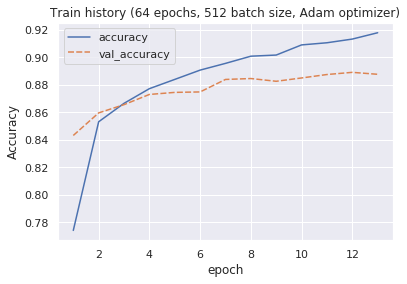

In [36]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val)

In [37]:
strftime('%X')

'00:07:53'

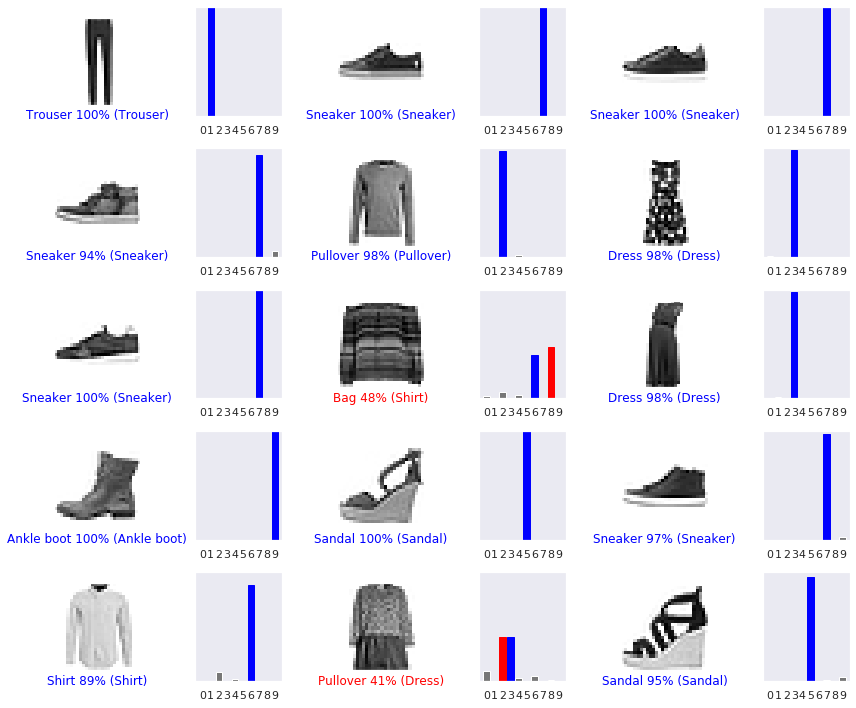

In [38]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

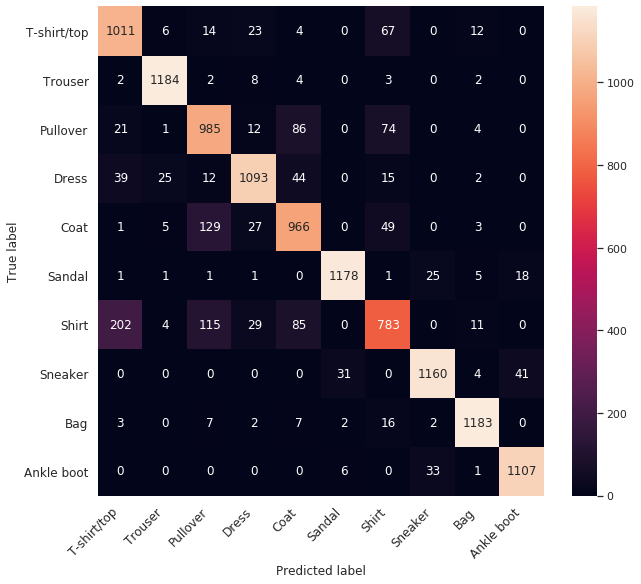

In [39]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

### 1.2. CNN

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [0]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [42]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [43]:
conv_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [44]:
strftime('%X')

'00:07:59'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 134us/sample - loss: 0.7309 - accuracy: 0.7599 - val_loss: 0.4810 - val_accuracy: 0.8378
Epoch 2/64
48000/48000 [==============================] - 3s 55us/sample - loss: 0.4384 - accuracy: 0.8536 - val_loss: 0.4110 - val_accuracy: 0.8619
Epoch 3/64
48000/48000 [==============================] - 3s 53us/sample - loss: 0.3875 - accuracy: 0.8712 - val_loss: 0.3708 - val_accuracy: 0.8767
Epoch 4/64
48000/48000 [==============================] - 3s 57us/sample - loss: 0.3564 - accuracy: 0.8818 - val_loss: 0.3515 - val_accuracy: 0.8851
Epoch 5/64
48000/48000 [==============================] - 3s 54us/sample - loss: 0.3393 - accuracy: 0.8897 - val_loss: 0.3375 - val_accuracy: 0.8903
Epoch 6/64
48000/48000 [==============================] - 2s 52us/sample - loss: 0.3183 - accuracy: 0.8961 - val_loss: 0.3283 - val_accuracy: 0.8967
Epoch 7/64
48000/48000 [==========

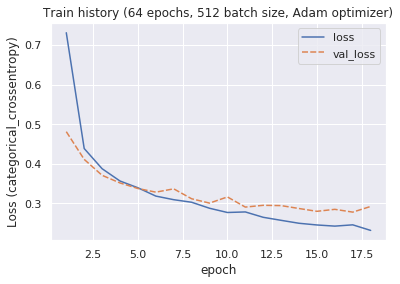

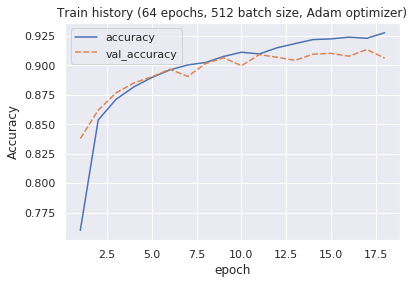

In [45]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val)

In [46]:
strftime('%X')

'00:08:51'

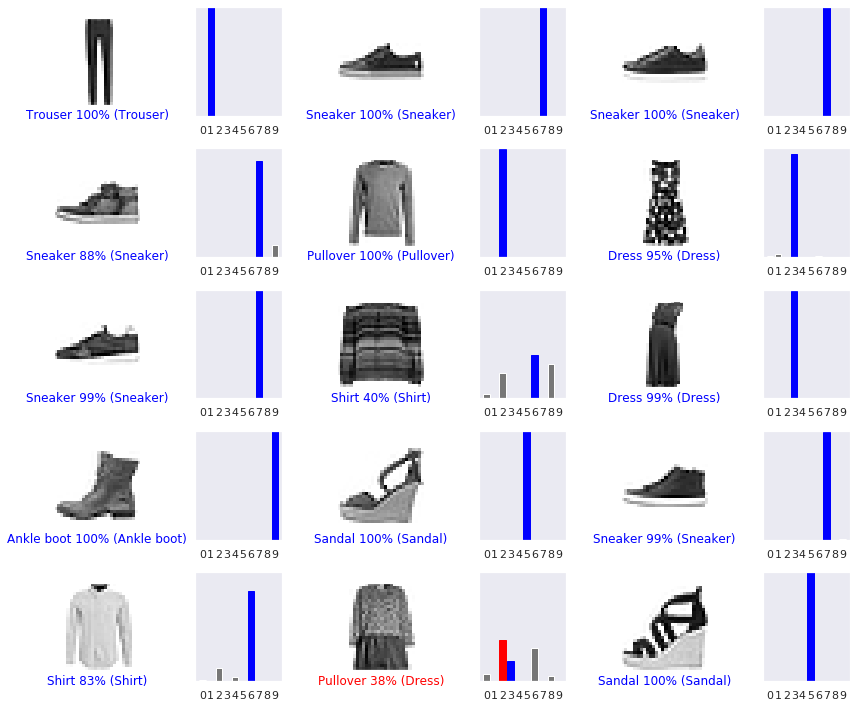

In [47]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

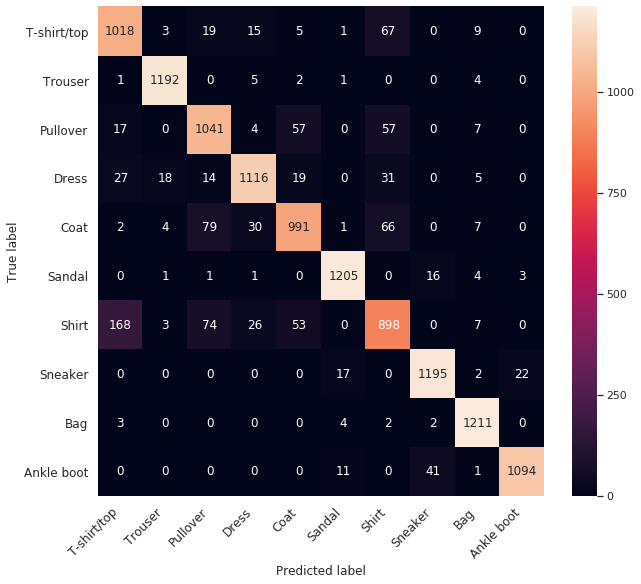

In [48]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [0]:
from sklearn.decomposition import PCA

In [0]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [51]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [0]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [0]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

### 2.1. 99% explained variance

In [54]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.9900491237640381 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 24us/sample - loss: 0.7852 - accuracy: 0.7464 - val_loss: 0.4512 - val_accuracy: 0.8501
Epoch 2/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3942 - accuracy: 0.8689 - val_loss: 0.3880 - val_accuracy: 0.8722
Epoch 3/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3355 - accuracy: 0.8896 - val_loss: 0.3652 - val_accuracy: 0.8792
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2982 - accuracy: 0.9019 - val_loss: 0.3535 - val_accuracy: 0.8814
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2698 - accuracy: 0.9126 - val_loss: 0.3491 - val_accuracy: 0.8827
Epoch 6/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.2458 - accuracy: 0.9218 - val_loss: 0.3449 - val_accuracy: 0.8845
Epoch 7/64
48000/48000 [===========

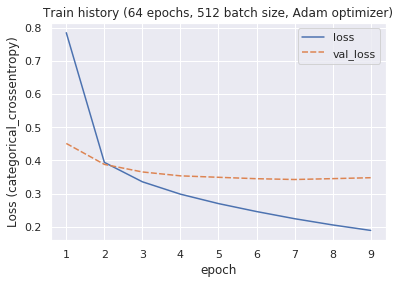

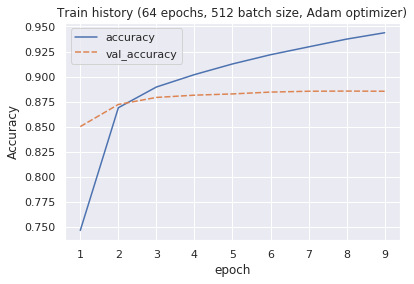

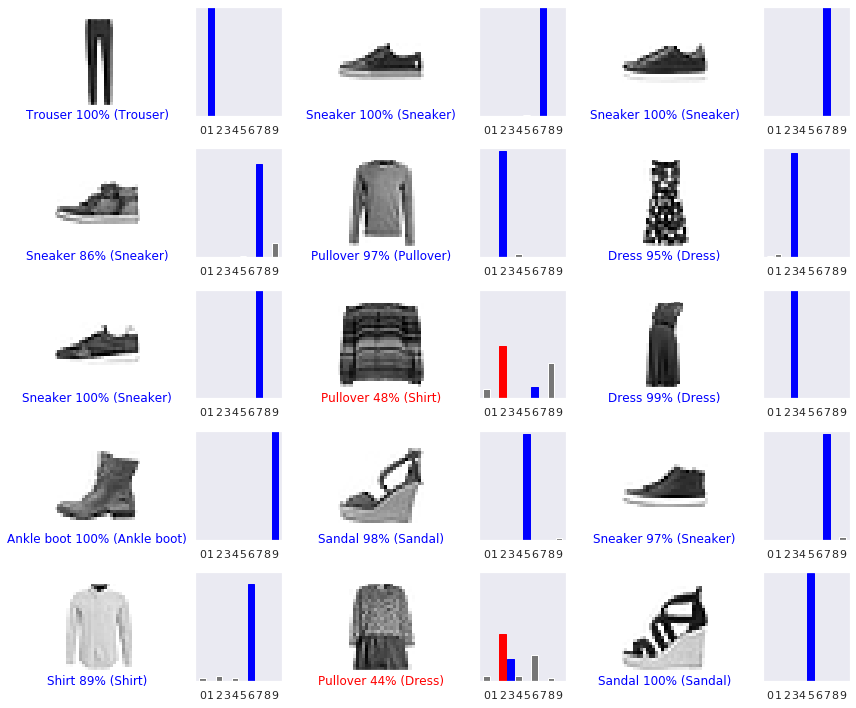

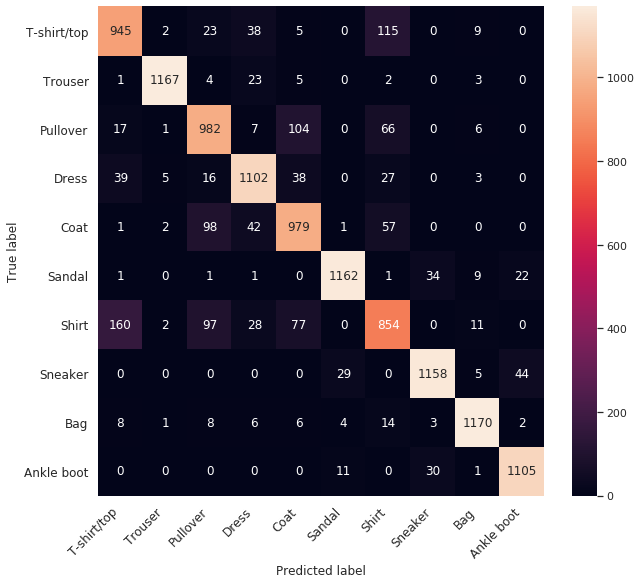

In [55]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

### 2.2. 95% explained variance

In [56]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9501577615737915 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 2s 33us/sample - loss: 0.7985 - accuracy: 0.7362 - val_loss: 0.4659 - val_accuracy: 0.8432
Epoch 2/64
48000/48000 [==============================] - 1s 16us/sample - loss: 0.4162 - accuracy: 0.8608 - val_loss: 0.4025 - val_accuracy: 0.8648
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3650 - accuracy: 0.8776 - val_loss: 0.3757 - val_accuracy: 0.8733
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3346 - accuracy: 0.8883 - val_loss: 0.3636 - val_accuracy: 0.8771
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3114 - accuracy: 0.8967 - val_loss: 0.3544 - val_accuracy: 0.8804
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2925 - accuracy: 0.9032 - val_loss: 0.3398 - val_accuracy: 0.8867
Epoch 7/64
48000/48000 [===========

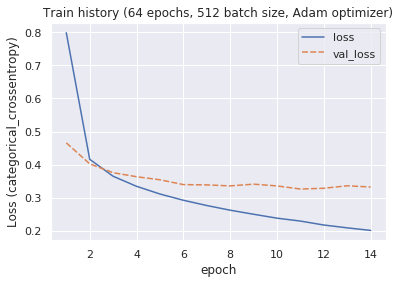

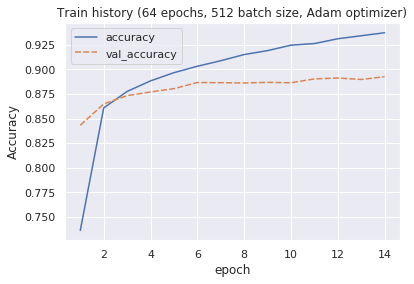

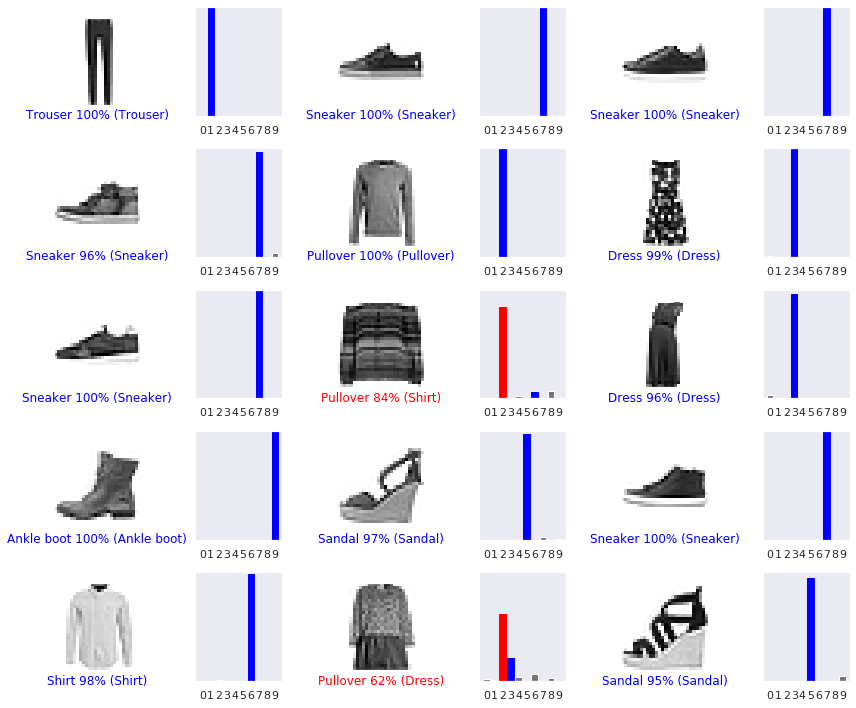

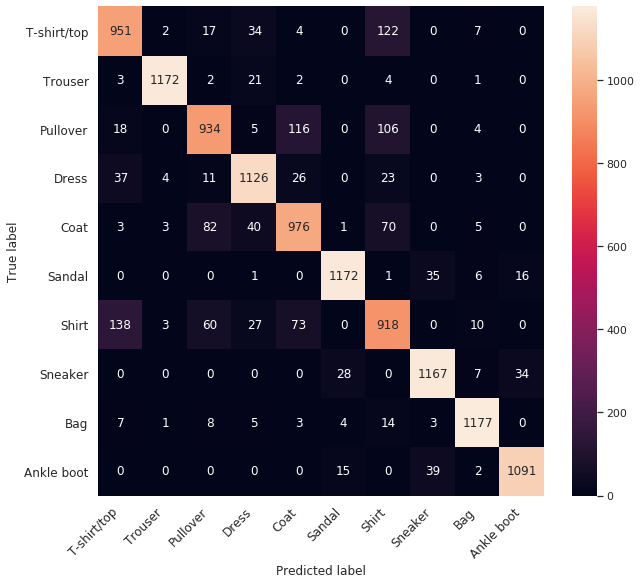

In [57]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

### 2.3. 90% explained variance

In [58]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006989598274231 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 2s 32us/sample - loss: 0.8477 - accuracy: 0.7251 - val_loss: 0.4881 - val_accuracy: 0.8289
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4430 - accuracy: 0.8492 - val_loss: 0.4259 - val_accuracy: 0.8532
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3931 - accuracy: 0.8645 - val_loss: 0.3938 - val_accuracy: 0.8648
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3638 - accuracy: 0.8744 - val_loss: 0.3822 - val_accuracy: 0.8674
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3449 - accuracy: 0.8814 - val_loss: 0.3675 - val_accuracy: 0.8723
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3287 - accuracy: 0.8873 - val_loss: 0.3643 - val_accuracy: 0.8758
Epoch 7/64
48000/48000 [===========

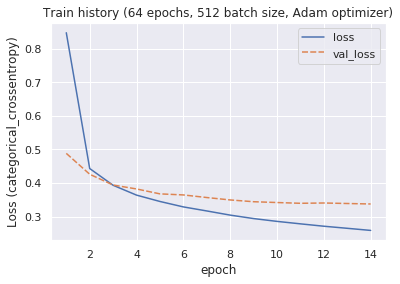

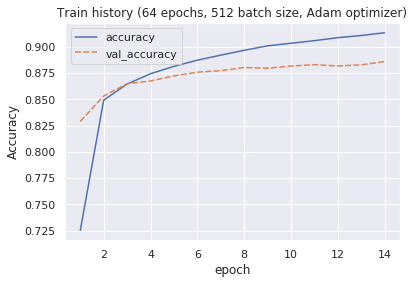

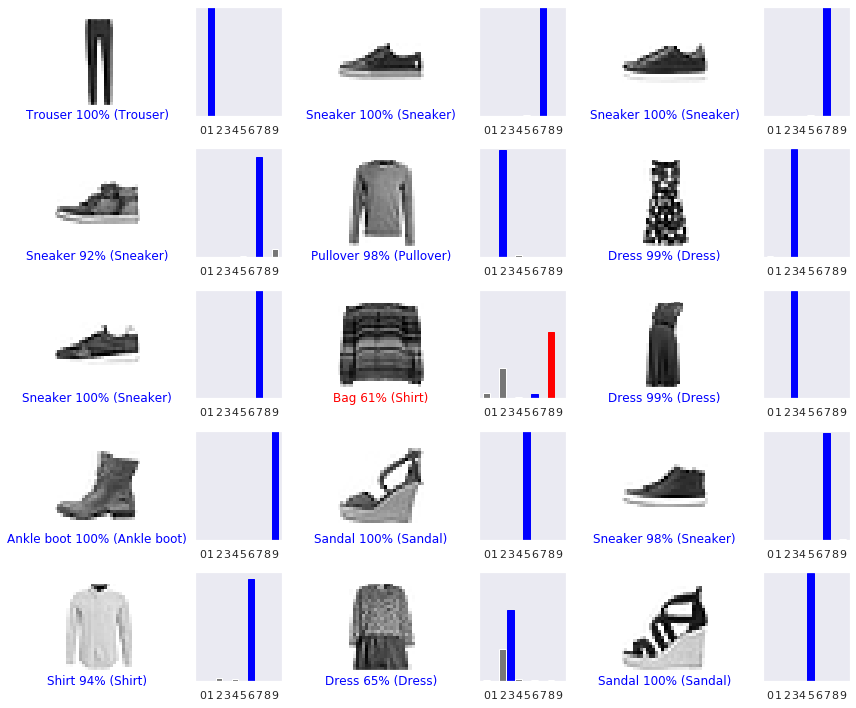

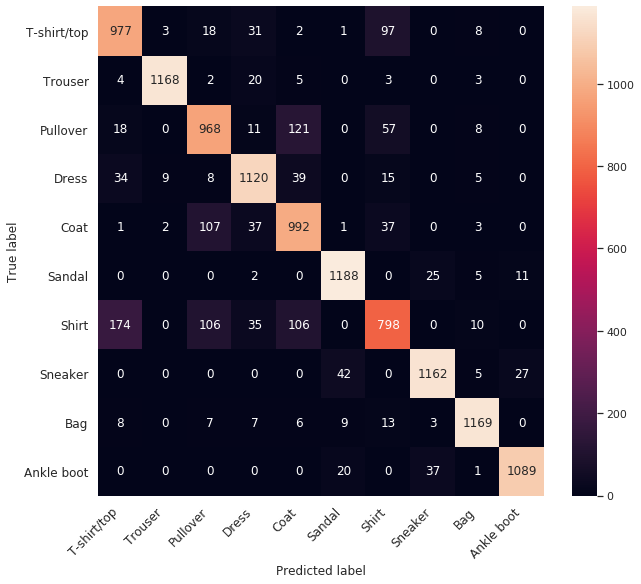

In [59]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

### 2.4. F1-scores

In [0]:
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {len(f1_score) / sum(1 / max(v, 1e-18) for v in f1_score):.4f}")
    print(f"Combined Precision: {len(precision) / sum(1 / max(v, 1e-18) for v in precision):.4f}")
    print(f"Combined Recall:    {len(recall) / sum(1 / max(v, 1e-18) for v in recall):.4f}")

In [62]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7898  |  0.8892  |  0.8366
Class 1 (Trouser):       0.9657  |  0.9826  |  0.9741
Class 2 (Pullover):      0.7787  |  0.8326  |  0.8047
Class 3 (Dress):         0.9146  |  0.8886  |  0.9014
Class 4 (Coat):          0.8077  |  0.8186  |  0.8131
Class 5 (Sandal):        0.9680  |  0.9569  |  0.9624
Class 6 (Shirt):         0.7768  |  0.6371  |  0.7000
Class 7 (Sneaker):       0.9508  |  0.9385  |  0.9446
Class 8 (Bag):           0.9641  |  0.9681  |  0.9661
Class 9 (Ankle boot):    0.9494  |  0.9651  |  0.9572

Combined F1 score:  0.8764
Combined Precision: 0.8787
Combined Recall:    0.8742


In [63]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8236  |  0.8953  |  0.8580
Class 1 (Trouser):       0.9762  |  0.9892  |  0.9827
Class 2 (Pullover):      0.8477  |  0.8800  |  0.8635
Class 3 (Dress):         0.9323  |  0.9073  |  0.9197
Class 4 (Coat):          0.8793  |  0.8398  |  0.8591
Class 5 (Sandal):        0.9718  |  0.9789  |  0.9753
Class 6 (Shirt):         0.8011  |  0.7307  |  0.7643
Class 7 (Sneaker):       0.9530  |  0.9668  |  0.9598
Class 8 (Bag):           0.9634  |  0.9910  |  0.9770
Class 9 (Ankle boot):    0.9777  |  0.9538  |  0.9656

Combined F1 score:  0.9068
Combined Precision: 0.9078
Combined Recall:    0.9059


In [64]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8063  |  0.8311  |  0.8185
Class 1 (Trouser):       0.9890  |  0.9685  |  0.9786
Class 2 (Pullover):      0.7990  |  0.8301  |  0.8143
Class 3 (Dress):         0.8837  |  0.8959  |  0.8898
Class 4 (Coat):          0.8064  |  0.8297  |  0.8179
Class 5 (Sandal):        0.9627  |  0.9439  |  0.9532
Class 6 (Shirt):         0.7518  |  0.6949  |  0.7222
Class 7 (Sneaker):       0.9453  |  0.9369  |  0.9411
Class 8 (Bag):           0.9614  |  0.9574  |  0.9594
Class 9 (Ankle boot):    0.9420  |  0.9634  |  0.9526

Combined F1 score:  0.8767
Combined Precision: 0.8770
Combined Recall:    0.8764


In [65]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8220  |  0.8364  |  0.8291
Class 1 (Trouser):       0.9890  |  0.9726  |  0.9808
Class 2 (Pullover):      0.8384  |  0.7895  |  0.8132
Class 3 (Dress):         0.8944  |  0.9154  |  0.9048
Class 4 (Coat):          0.8133  |  0.8271  |  0.8202
Class 5 (Sandal):        0.9607  |  0.9521  |  0.9563
Class 6 (Shirt):         0.7297  |  0.7469  |  0.7382
Class 7 (Sneaker):       0.9381  |  0.9442  |  0.9411
Class 8 (Bag):           0.9632  |  0.9632  |  0.9632
Class 9 (Ankle boot):    0.9562  |  0.9512  |  0.9537

Combined F1 score:  0.8827
Combined Precision: 0.8827
Combined Recall:    0.8826


In [66]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8035  |  0.8593  |  0.8304
Class 1 (Trouser):       0.9882  |  0.9693  |  0.9786
Class 2 (Pullover):      0.7961  |  0.8183  |  0.8070
Class 3 (Dress):         0.8868  |  0.9106  |  0.8985
Class 4 (Coat):          0.7805  |  0.8407  |  0.8095
Class 5 (Sandal):        0.9421  |  0.9651  |  0.9535
Class 6 (Shirt):         0.7824  |  0.6493  |  0.7096
Class 7 (Sneaker):       0.9470  |  0.9401  |  0.9436
Class 8 (Bag):           0.9606  |  0.9566  |  0.9586
Class 9 (Ankle boot):    0.9663  |  0.9494  |  0.9578

Combined F1 score:  0.8758
Combined Precision: 0.8777
Combined Recall:    0.8738


### 2.4. <90% explained variance

### 2.4.1. 80% explained variance

In [67]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8008705377578735 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 30us/sample - loss: 0.8570 - accuracy: 0.7152 - val_loss: 0.5447 - val_accuracy: 0.8088
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.5071 - accuracy: 0.8229 - val_loss: 0.4785 - val_accuracy: 0.8347
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4600 - accuracy: 0.8396 - val_loss: 0.4511 - val_accuracy: 0.8428
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4347 - accuracy: 0.8497 - val_loss: 0.4368 - val_accuracy: 0.8468
Epoch 5/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.4178 - accuracy: 0.8558 - val_loss: 0.4269 - val_accuracy: 0.8492
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4042 - accuracy: 0.8598 - val_loss: 0.4234 - val_accuracy: 0.8529
Epoch 7/64
48000/48000 [===========

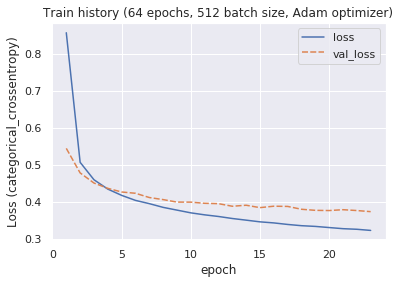

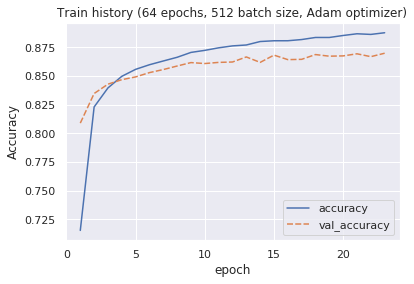

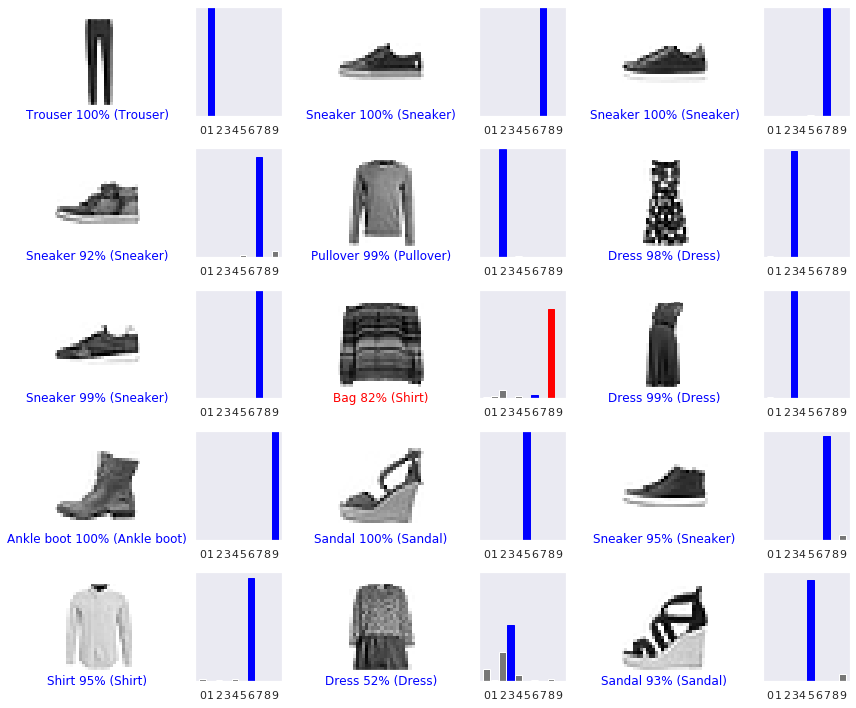

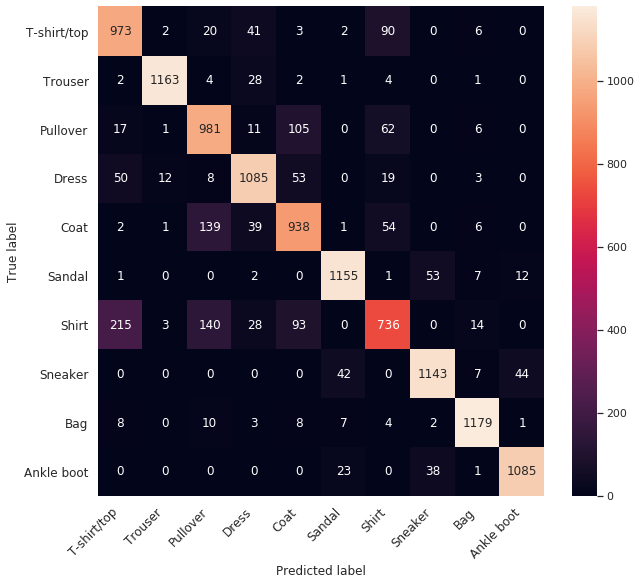

In [68]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [69]:
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7674  |  0.8558  |  0.8091
Class 1 (Trouser):       0.9839  |  0.9651  |  0.9744
Class 2 (Pullover):      0.7535  |  0.8292  |  0.7895
Class 3 (Dress):         0.8771  |  0.8821  |  0.8796
Class 4 (Coat):          0.7804  |  0.7949  |  0.7876
Class 5 (Sandal):        0.9383  |  0.9383  |  0.9383
Class 6 (Shirt):         0.7588  |  0.5989  |  0.6694
Class 7 (Sneaker):       0.9248  |  0.9248  |  0.9248
Class 8 (Bag):           0.9585  |  0.9648  |  0.9617
Class 9 (Ankle boot):    0.9501  |  0.9459  |  0.9480

Combined F1 score:  0.8568
Combined Precision: 0.8599
Combined Recall:    0.8538


### 2.4.2. 60% explained variance

In [70]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6156876087188721 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 31us/sample - loss: 0.9686 - accuracy: 0.6533 - val_loss: 0.7700 - val_accuracy: 0.7057
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.7499 - accuracy: 0.7178 - val_loss: 0.7327 - val_accuracy: 0.7240
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.7224 - accuracy: 0.7262 - val_loss: 0.7123 - val_accuracy: 0.7308
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.7076 - accuracy: 0.7319 - val_loss: 0.7080 - val_accuracy: 0.7256
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.6975 - accuracy: 0.7337 - val_loss: 0.6972 - val_accuracy: 0.7382
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.6882 - accuracy: 0.7369 - val_loss: 0.6909 - val_accuracy: 0.7381
Epoch 7/64
48000/48000 [===========

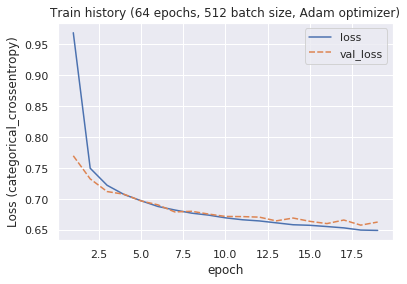

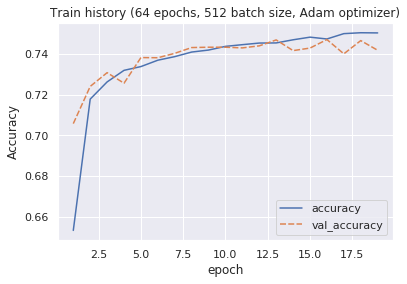

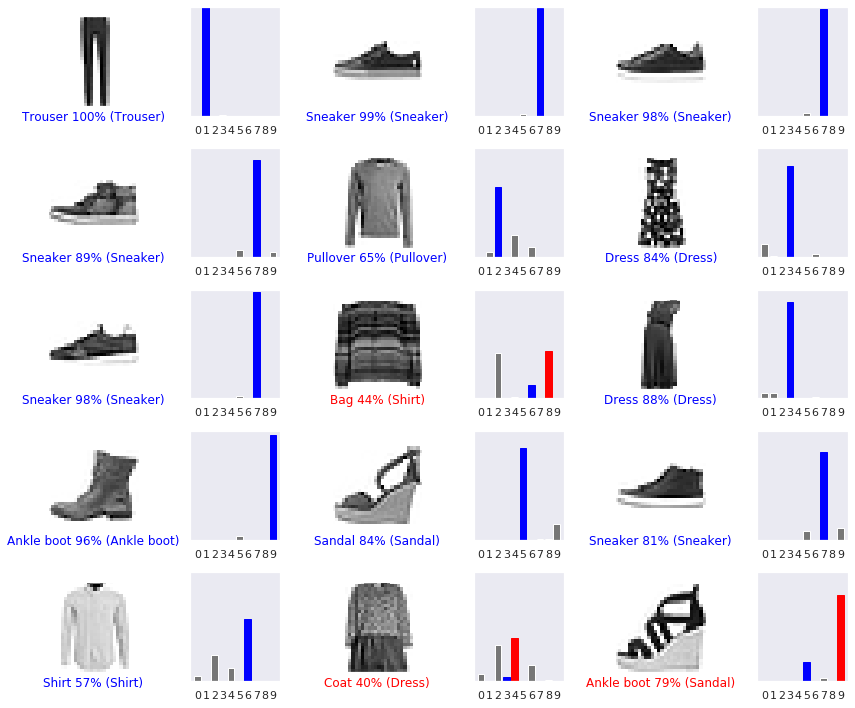

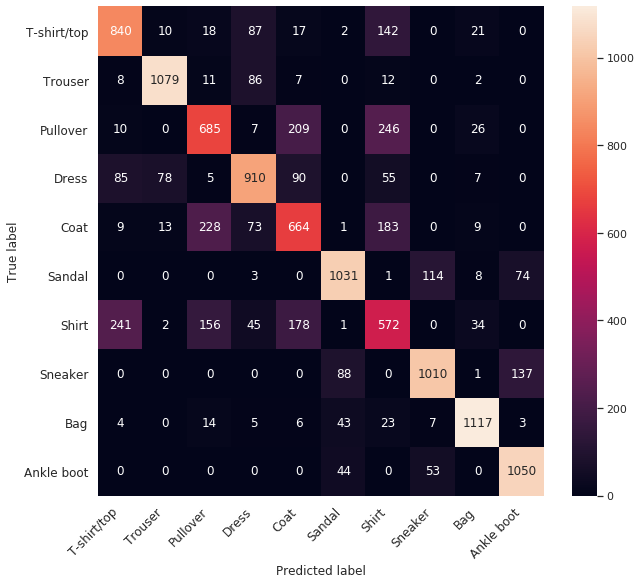

In [71]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [72]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7018  |  0.7388  |  0.7198
Class 1 (Trouser):       0.9129  |  0.8954  |  0.9041
Class 2 (Pullover):      0.6132  |  0.5790  |  0.5957
Class 3 (Dress):         0.7484  |  0.7398  |  0.7441
Class 4 (Coat):          0.5670  |  0.5627  |  0.5649
Class 5 (Sandal):        0.8521  |  0.8375  |  0.8447
Class 6 (Shirt):         0.4635  |  0.4654  |  0.4645
Class 7 (Sneaker):       0.8530  |  0.8172  |  0.8347
Class 8 (Bag):           0.9118  |  0.9141  |  0.9130
Class 9 (Ankle boot):    0.8307  |  0.9154  |  0.8710

Combined F1 score:  0.7109
Combined Precision: 0.7115
Combined Recall:    0.7103


### 2.5. Plot the first 3 principal components

In [0]:
pca_3pc = PCA(n_components=3)

In [0]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [75]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2896 (cumulative sum: 0.29)
PC 2: 0.1775 (cumulative sum: 0.47)
PC 3: 0.0606 (cumulative sum: 0.53)


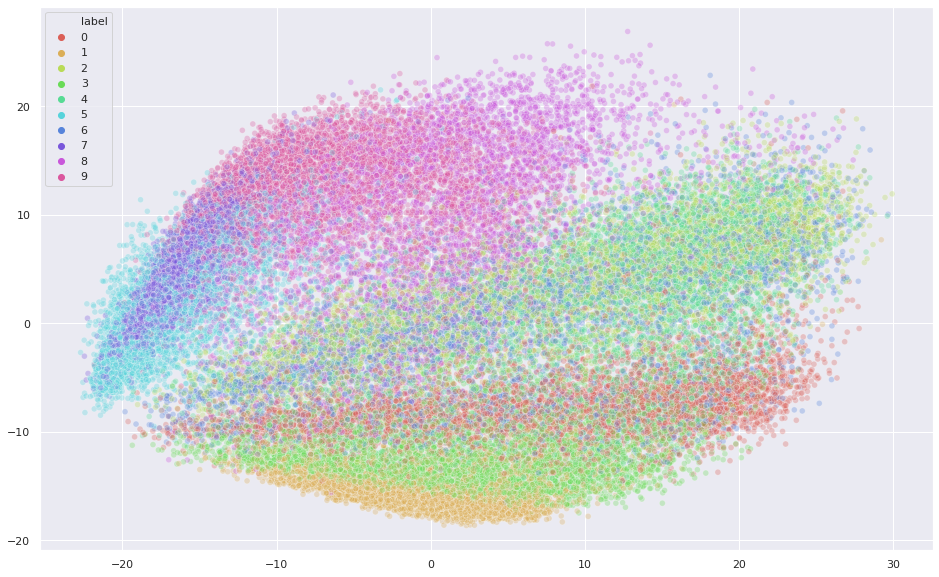

In [76]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [0]:
from mpl_toolkits.mplot3d import Axes3D

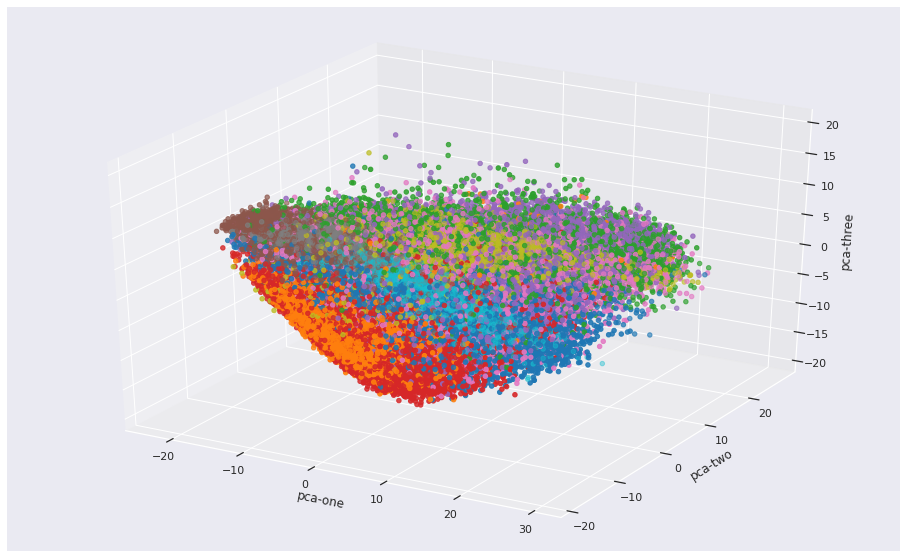

In [78]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [0]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

In [0]:
def build_autoencoder(latent_dim):
    __input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
    __encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
    __decoded = Dense(784, activation='sigmoid')(__encoded)

    autoencoder = Model(__input, __decoded)
    print("\nAutoencoder summary:")
    print(autoencoder.summary())

    encoder = Model(__input, __encoded)
    print("\nEncoder summary:")
    print(encoder.summary())

    # create a placeholder for an encoded (24-dimensional) input
    encoded_input = Input(shape=(latent_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    print("\nDecoder summary:")
    print(decoder.summary())

    autoencoder.compile(optimizer='adam', loss='mse')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

    autoencoder.fit(X_train, X_train,
                    validation_data=(X_val, X_val),
                    epochs=MAX_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=TF_VERBOSE)
    return autoencoder, encoder, decoder

In [0]:
def show_autoencoder_samples(encoder, decoder):
    encoded_imgs = encoder.predict(X_val)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
def train_ae_model(encoder, latent_dim, model_name):
    model = keras.Sequential([
        Input(shape=(latent_dim, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)

    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_ae, best_model_ae = train(model, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred, best_model_ae

### 3.1. Latent vector size of 84

In [0]:
latent_dim = 84

In [84]:
autoencoder_84, encoder_84, decoder_84 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                65940     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               66640     
Total params: 132,580
Trainable params: 132,580
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                6594

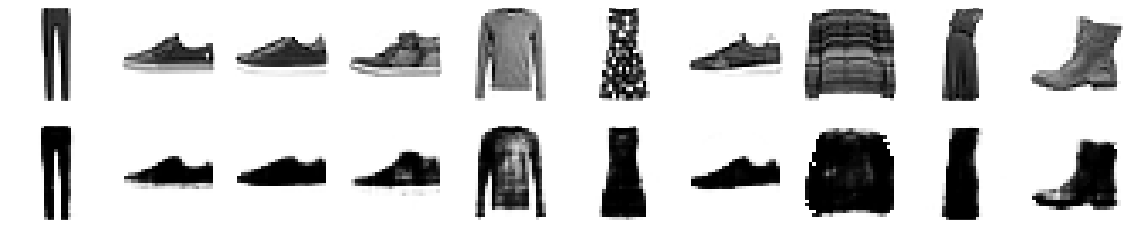

In [85]:
show_autoencoder_samples(encoder_84, decoder_84)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 24us/sample - loss: 0.8777 - accuracy: 0.7133 - val_loss: 0.5100 - val_accuracy: 0.8284
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4763 - accuracy: 0.8371 - val_loss: 0.4478 - val_accuracy: 0.8462
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4292 - accuracy: 0.8522 - val_loss: 0.4241 - val_accuracy: 0.8543
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4004 - accuracy: 0.8619 - val_loss: 0.4019 - val_accuracy: 0.8589
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3825 - accuracy: 0.8684 - val_loss: 0.3949 - val_accuracy: 0.8602
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3669 - accuracy: 0.8732 - val_loss: 0.3811 - val_accuracy: 0.8648
Epoch 7/64
48000/48000 [===========

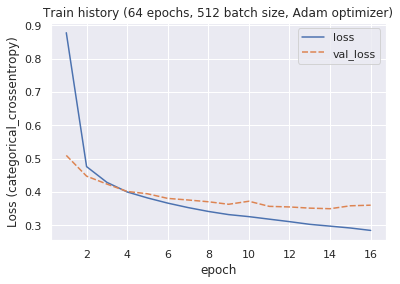

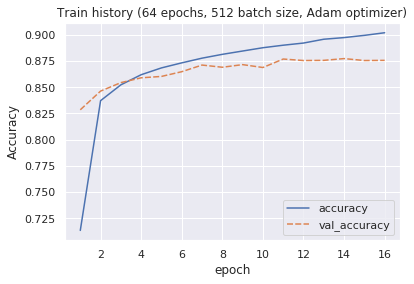

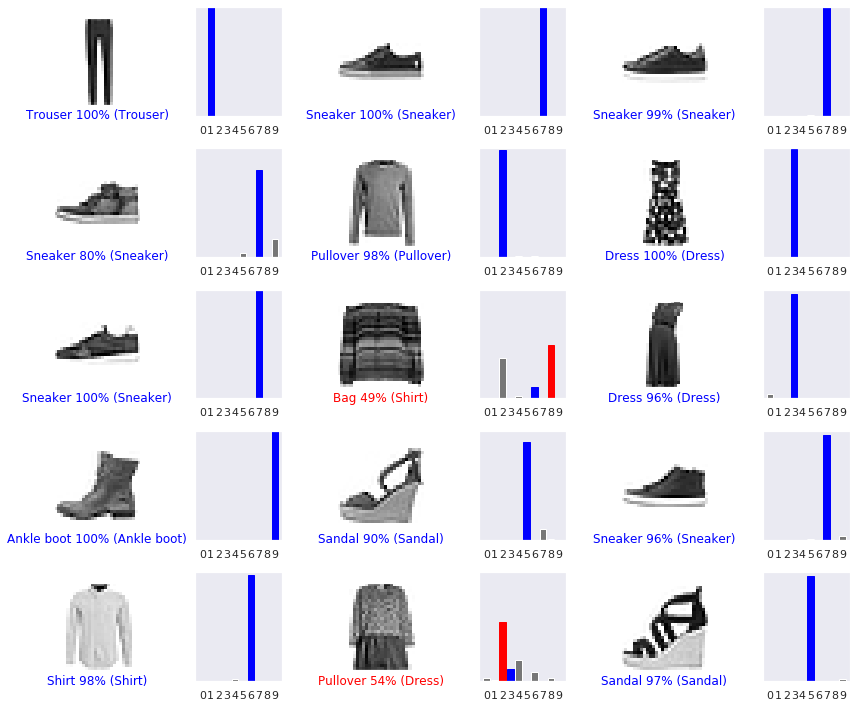

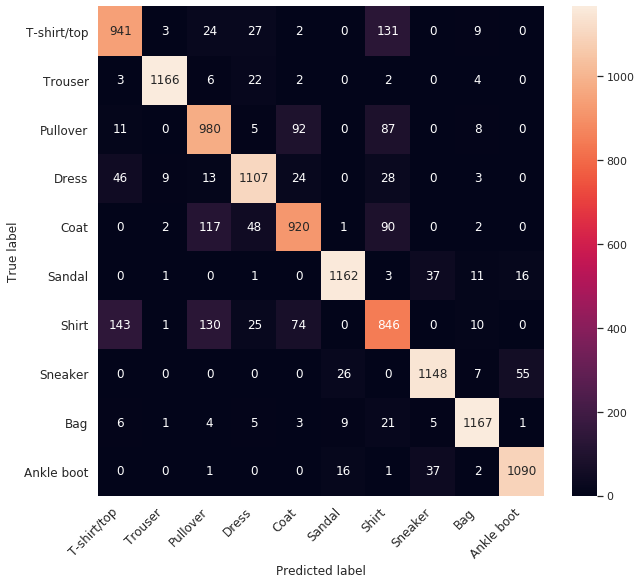

In [86]:
Y_val_ae_84_pred, model_ae_84 = train_ae_model(encoder_84, latent_dim, model_name="AE_84")

In [87]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_84_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8183  |  0.8276  |  0.8229
Class 1 (Trouser):       0.9856  |  0.9676  |  0.9765
Class 2 (Pullover):      0.7686  |  0.8284  |  0.7974
Class 3 (Dress):         0.8927  |  0.9000  |  0.8964
Class 4 (Coat):          0.8236  |  0.7797  |  0.8010
Class 5 (Sandal):        0.9572  |  0.9439  |  0.9505
Class 6 (Shirt):         0.6998  |  0.6884  |  0.6940
Class 7 (Sneaker):       0.9356  |  0.9288  |  0.9322
Class 8 (Bag):           0.9542  |  0.9550  |  0.9546
Class 9 (Ankle boot):    0.9380  |  0.9503  |  0.9441

Combined F1 score:  0.8673
Combined Precision: 0.8674
Combined Recall:    0.8672


### 3.2. Latent vector size of 24

In [0]:
latent_dim = 24

In [89]:
autoencoder_24, encoder_24, decoder_24 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                18840     
_________________________________________________________________
dense_25 (Dense)             (None, 784)               19600     
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                1884

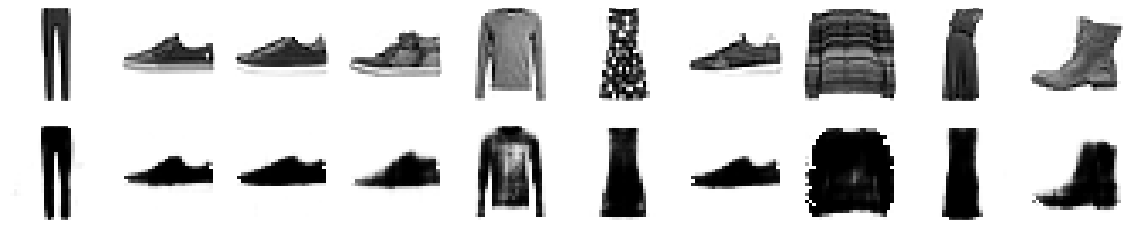

In [90]:
show_autoencoder_samples(encoder_24, decoder_24)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 24us/sample - loss: 0.8674 - accuracy: 0.7178 - val_loss: 0.5523 - val_accuracy: 0.8056
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.5178 - accuracy: 0.8202 - val_loss: 0.4987 - val_accuracy: 0.8269
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4705 - accuracy: 0.8366 - val_loss: 0.4721 - val_accuracy: 0.8321
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4481 - accuracy: 0.8436 - val_loss: 0.4560 - val_accuracy: 0.8404
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4338 - accuracy: 0.8474 - val_loss: 0.4481 - val_accuracy: 0.8403
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4197 - accuracy: 0.8534 - val_loss: 0.4376 - val_accuracy: 0.8462
Epoch 7/64
48000/48000 [===========

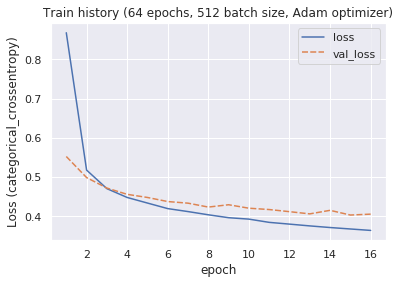

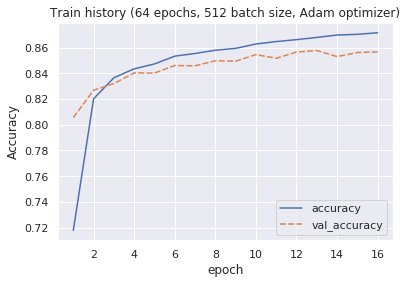

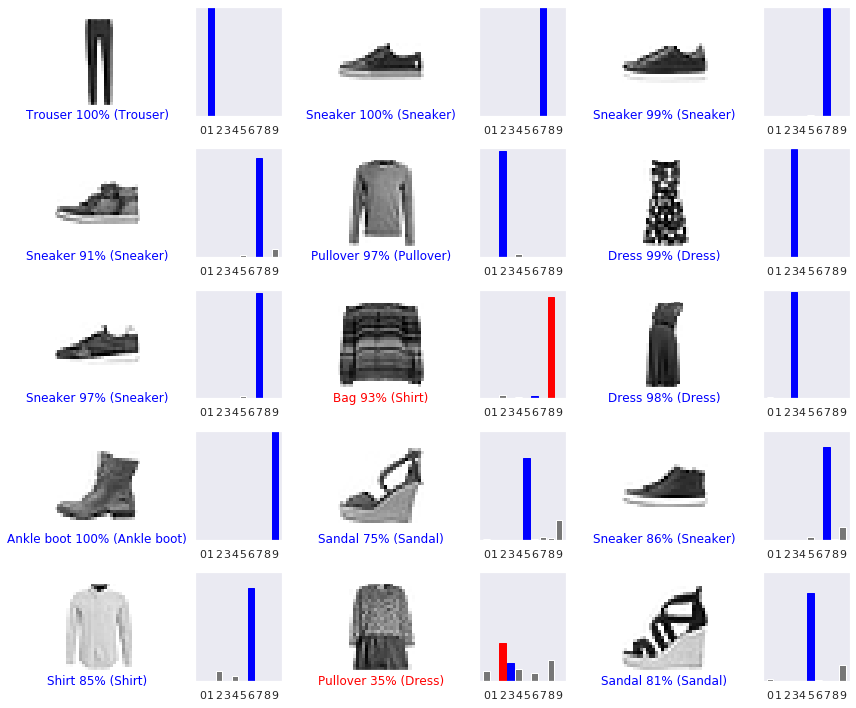

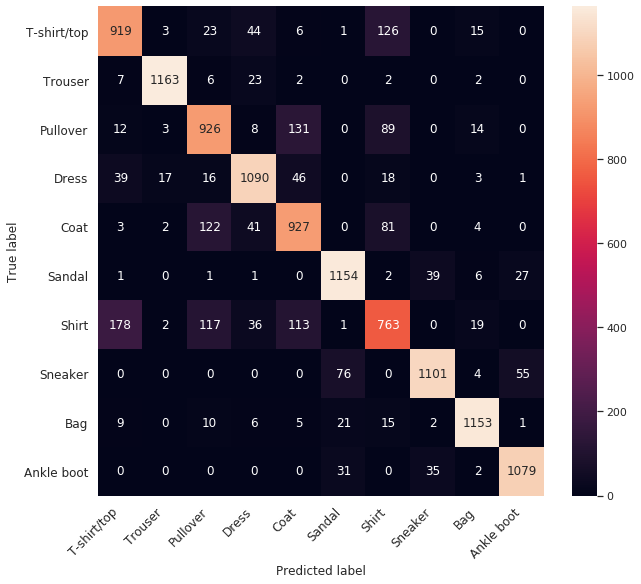

In [91]:
Y_val_ae_24_pred, model_ae_24 = train_ae_model(encoder_24, latent_dim, model_name="AE_24")

In [92]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_24_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7868  |  0.8083  |  0.7974
Class 1 (Trouser):       0.9773  |  0.9651  |  0.9712
Class 2 (Pullover):      0.7584  |  0.7828  |  0.7704
Class 3 (Dress):         0.8727  |  0.8862  |  0.8794
Class 4 (Coat):          0.7537  |  0.7856  |  0.7693
Class 5 (Sandal):        0.8988  |  0.9374  |  0.9177
Class 6 (Shirt):         0.6962  |  0.6208  |  0.6563
Class 7 (Sneaker):       0.9354  |  0.8908  |  0.9126
Class 8 (Bag):           0.9435  |  0.9435  |  0.9435
Class 9 (Ankle boot):    0.9278  |  0.9407  |  0.9342

Combined F1 score:  0.8433
Combined Precision: 0.8445
Combined Recall:    0.8421


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

In [0]:
def show_clusters(clusters, data):
    print("Clusters:", set(clusters.labels_))

    print("Adjusted Rand Score:", adjusted_rand_score(ys_val, clusters.labels_))

    labels = clusters.labels_.astype(float)
    # we select the first two feature columns for plotting in 2D
    __xs, __ys = data[..., 0], data[..., 1]

    try:
        centroids = clusters.cluster_centers_ # K-Means
        __xc, __yc = centroids[..., 0], centroids[..., 1]
    except:
        centroids = None

    # plt.scatter(x=__xs, y=__ys, c=labels, s=50, alpha=0.8, cmap="viridis")
    # plt.scatter(__xc, __yc, marker='+', s=169, linewidths=3, color='red', zorder=10)
    
    plt.figure(figsize=(16, 10))
    sns.scatterplot(x=__xs, y=__ys, 
                    hue=labels, palette=sns.color_palette("hls", 10), legend="full", alpha=0.3)
    if centroids is not None:
        sns.scatterplot(x=__xc, y=__yc, 
                        marker='+', s=175, linewidths=3, color='black', zorder=10)
    plt.show()

## 4.0. Mini-Batch K-Means

Let's standardize the features we'll be using for clustering with the Z-transform:

In [208]:
reduced_features = [("X_val_ae_24", X_val_ae_24), ("X_val_ae_84", X_val_ae_84), ("X_val_80var", X_val_80var), ("X_val_90var", X_val_90var)]
reduced_features_stdzd = [] # Z-transform standardized
for name, array in reduced_features:
    print(f"{name+':':<18} {str(array.shape):<11} "
          f"| min: {array.min():>6.2f} | max: {array.max():>6.2f} "
          f"| mean: {array.mean():>6.3f} | std: {array.std():>6.3f}")
    reduced_features_stdzd.append((name + "_stdzd", (array - array.mean()) / array.std()))
for name, array in reduced_features_stdzd:
    print(f"{name+':':<18} {str(array.shape):<11} "
          f"| min: {array.min():>6.2f} | max: {array.max():>6.2f} "
          f"| mean: {array.mean():>6.3f} | std: {array.std():>6.3f}")

X_val_ae_24:       (12000, 24) | min:   0.00 | max:  44.27 | mean:  5.044 | std:  5.814
X_val_ae_84:       (12000, 84) | min:   0.00 | max:  38.08 | mean:  1.599 | std:  2.521
X_val_80var:       (12000, 24) | min: -22.32 | max:  30.72 | mean: -0.003 | std:  4.271
X_val_90var:       (12000, 84) | min: -22.32 | max:  30.72 | mean: -0.001 | std:  2.421
X_val_ae_24_stdzd: (12000, 24) | min:  -0.87 | max:   6.75 | mean: -0.000 | std:  1.000
X_val_ae_84_stdzd: (12000, 84) | min:  -0.63 | max:  14.47 | mean: -0.000 | std:  1.000
X_val_80var_stdzd: (12000, 24) | min:  -5.23 | max:   7.19 | mean:  0.000 | std:  1.000
X_val_90var_stdzd: (12000, 84) | min:  -9.22 | max:  12.69 | mean:  0.000 | std:  1.000


X_val_ae_24_stdzd
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.27874846703223394


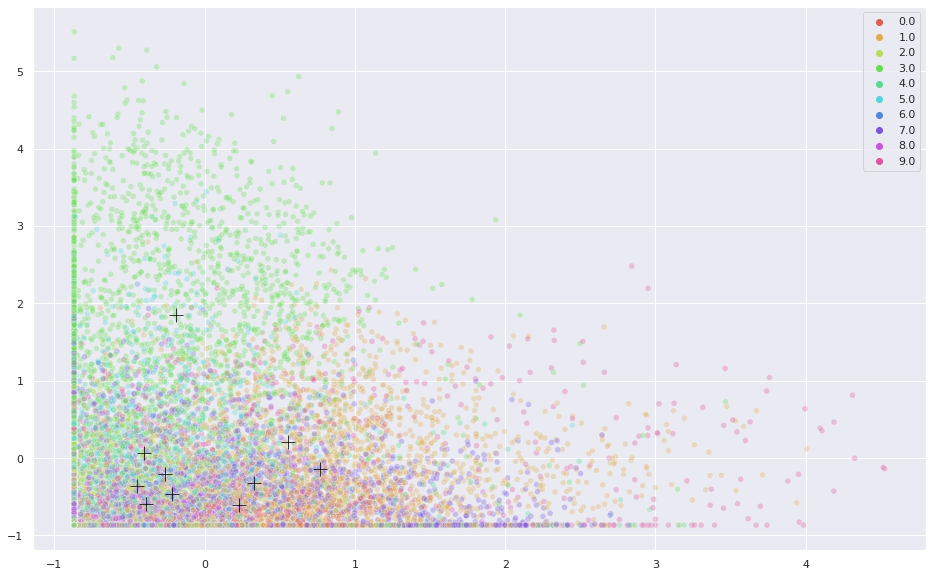

X_val_ae_84_stdzd
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.34816166430776985


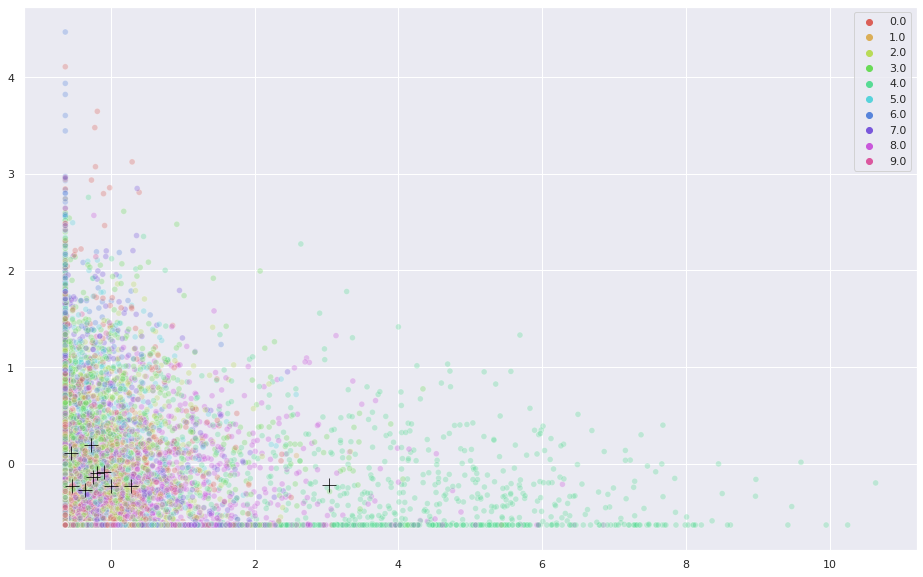

X_val_80var_stdzd
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3216298797009126


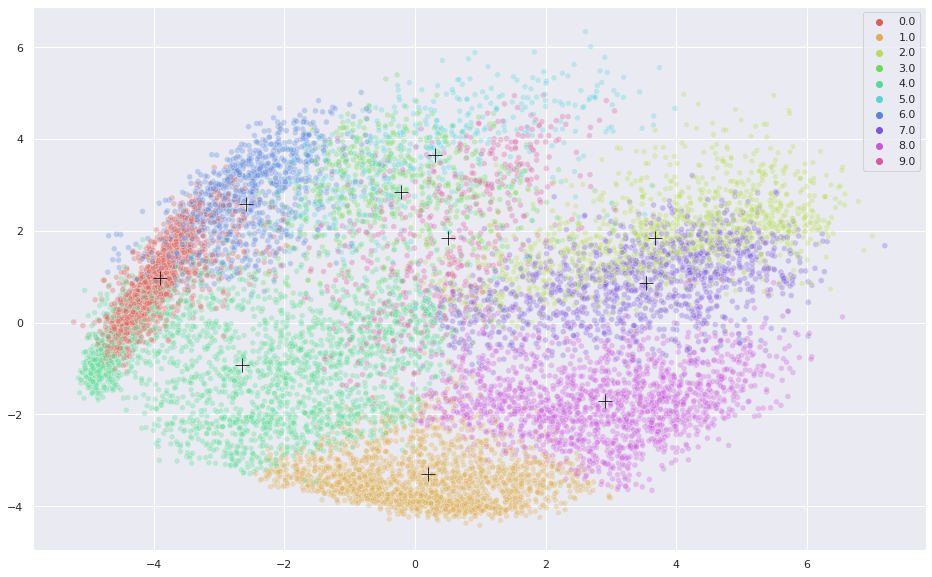

X_val_90var_stdzd
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.2977448969517024


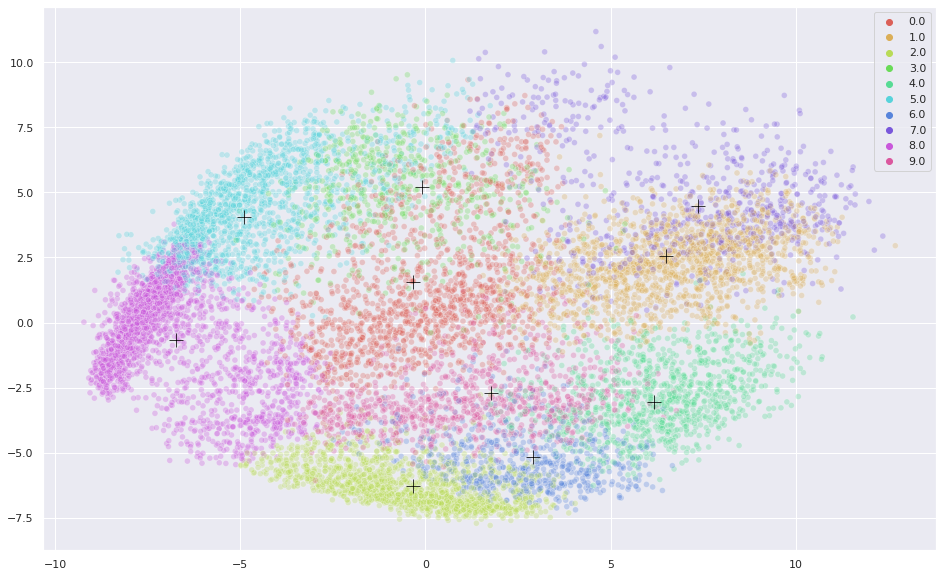

In [218]:
for name, reduced_feature in reduced_features_stdzd:
    print(name)
    mbkmeans = MiniBatchKMeans(n_clusters=10).fit(reduced_feature)
    show_clusters(mbkmeans, reduced_feature)

### 4.1. K-Means

In [0]:
# FIXME Autoencoder clustering looks really odd

### 4.1.1. Autoencoder reduced features (24 latent vector size)

In [0]:
X_val_ae_24 = encoder_24.predict(X_val)

In [0]:
kmeans_ae_24 = KMeans(n_clusters=10).fit(X_val_ae_24)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.31791091262812127


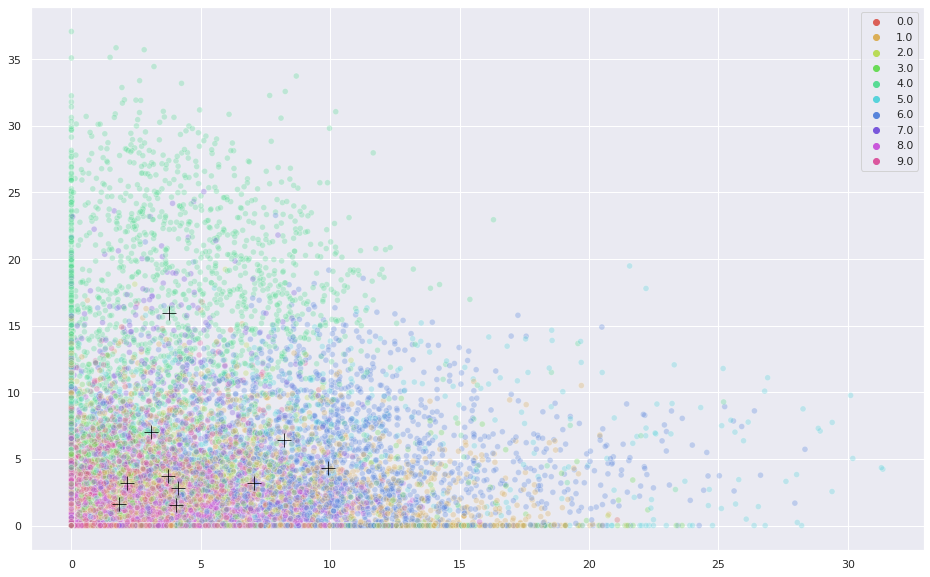

In [149]:
show_clusters(kmeans_ae_24, X_val_ae_24)

### 4.1.2. Autoencoder reduced features (84 latent vector size)

In [0]:
X_val_ae_84 = encoder_84.predict(X_val)

In [0]:
kmeans_ae_84 = KMeans(n_clusters=10).fit(X_val_ae_84)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3681830780588952


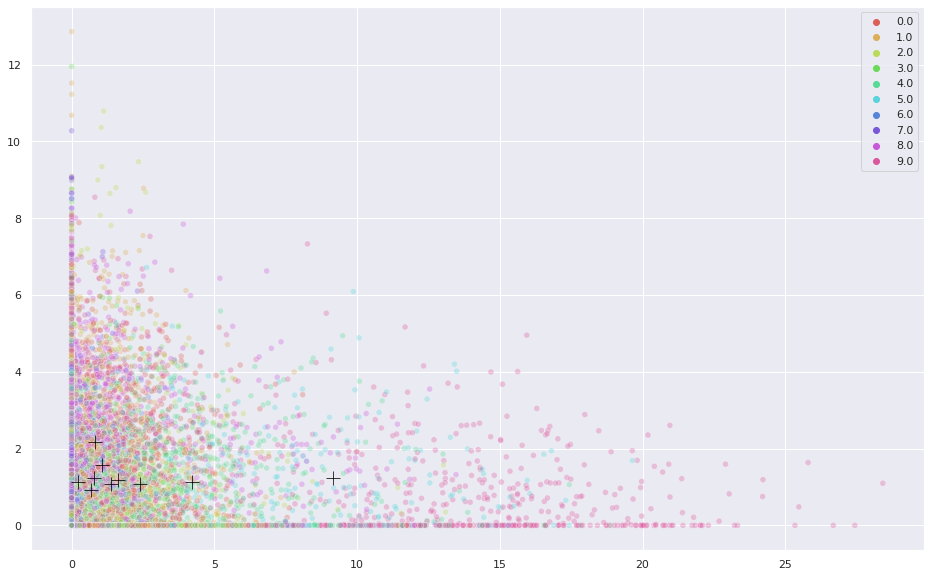

In [152]:
show_clusters(kmeans_ae_84, X_val_ae_84)

### 4.1.3. PCA reduced features (80% explained variance, 24 principal components)

In [0]:
X_val_80var = pca_80var.transform(X_val)

In [0]:
kmeans_pca_80var = KMeans(n_clusters=10).fit(X_val_80var)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3693381993155833


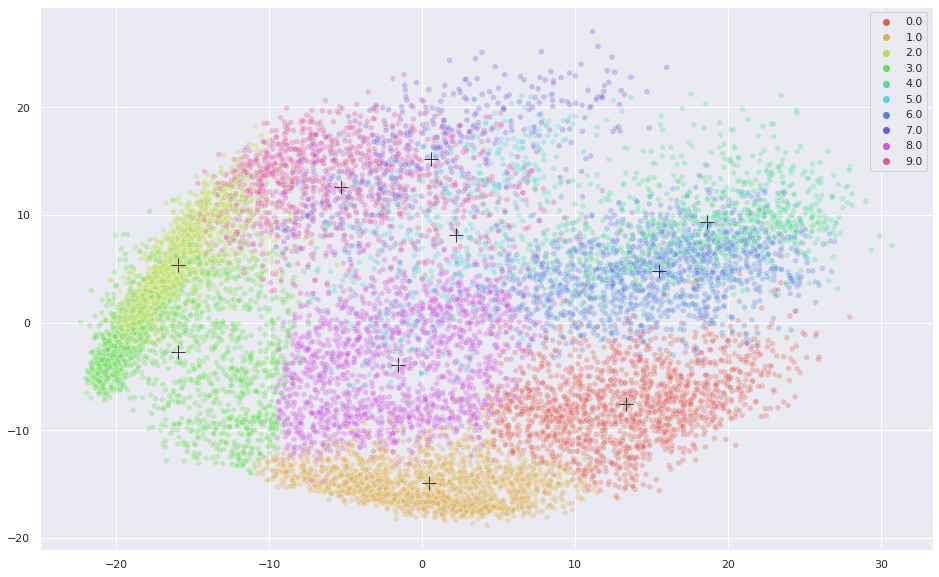

In [155]:
show_clusters(kmeans_pca_80var, X_val_80var)

### 4.1.4. PCA reduced features (90% explained variance, 84 principal components)

In [0]:
X_val_90var = pca_90var.transform(X_val)

In [0]:
kmeans_pca_90var = KMeans(n_clusters=10).fit(X_val_90var)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.36953460916507935


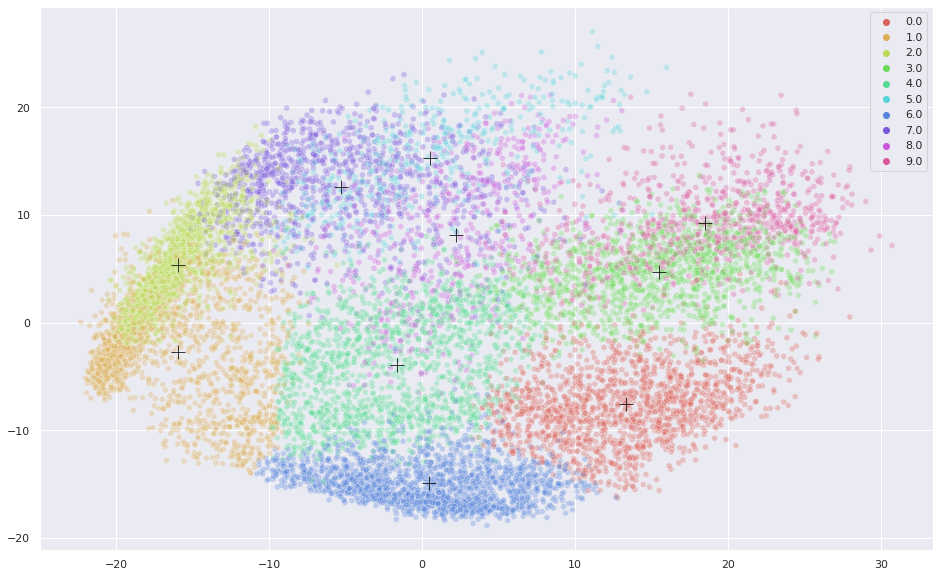

In [158]:
show_clusters(kmeans_pca_90var, X_val_90var)

## 4.2. Agglomerative clustering

### 4.2.1. PCA reduced features (80% explained variance, 24 principal components)

In [0]:
agglomerative_pca_80var = AgglomerativeClustering(n_clusters=10).fit(X_val_80var)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3829911713629829


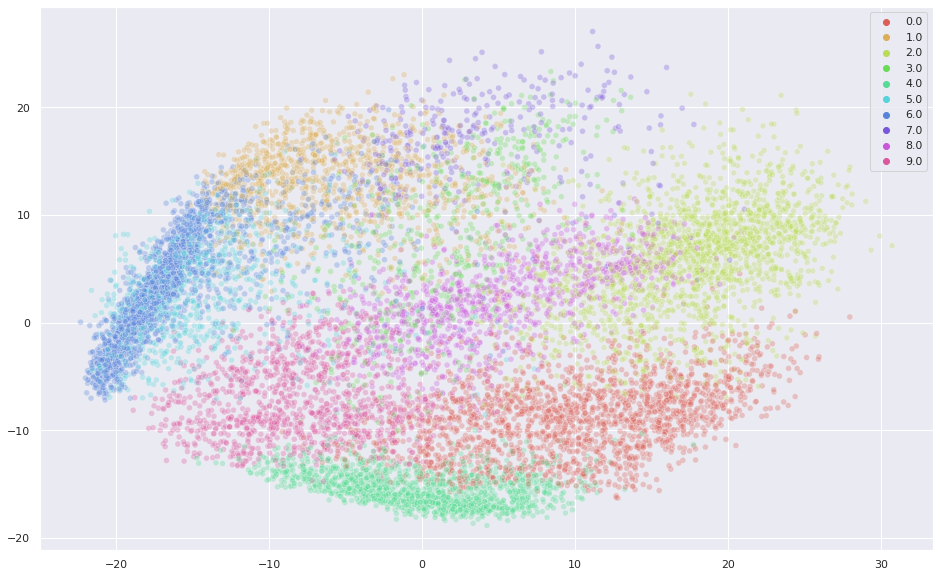

In [180]:
show_clusters(agglomerative_pca_80var, X_val_80var)

### 4.2.2. PCA reduced features (90% explained variance, 84 principal components)

In [0]:
agglomerative_pca_90var = AgglomerativeClustering(n_clusters=10).fit(X_val_90var)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3829911713629829


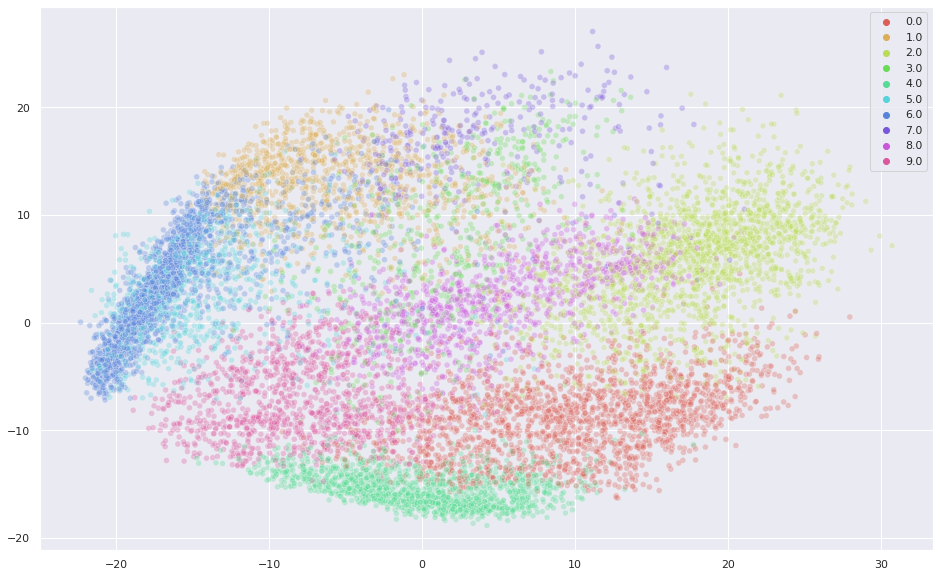

In [188]:
show_clusters(agglomerative_pca_80var, X_val_90var)

In [109]:
strftime('%X')

'00:12:32'